In [23]:
import numpy as np
import wget 
import matplotlib.pyplot as plt

In [21]:
url = "https://images.unsplash.com/photo-1561731216-c3a4d99437d5?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=928&q=80"


In [22]:
IMG_PATH = wget.download(url)

In [ ]:
class Processing:

        def __init__(self, img_shape:tuple):
            
            sef

3229440 Value
150528 Value


/tmp/ipykernel_39222/3311380029.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_resize = img_pil.resize((img_size, img_size), Image.ANTIALIAS)


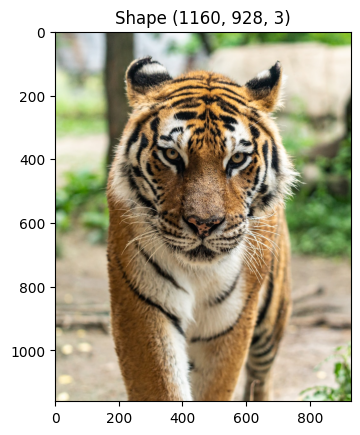

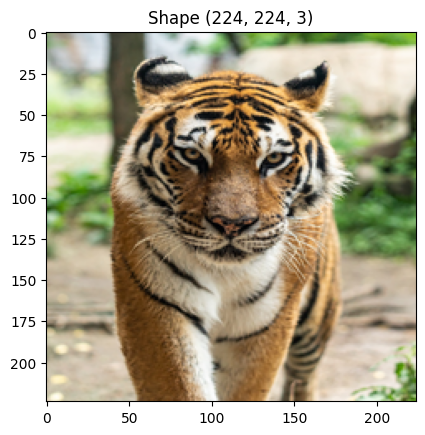

In [31]:
import cv2
from PIL import Image
from PIL.Image import fromarray


def load_and_prep_image(img_path, img_size=28):

    img_array = plt.imread(img_path) #cv2.IMREAD_GRAYSCALE
    plt.figure()
    plt.imshow(img_array)
    plt.title(f"Shape {img_array.shape}");
    print(1160 * 928 * 3, "Value")
    
    img_pil = fromarray(img_array)
    img_resize = img_pil.resize((img_size, img_size), Image.ANTIALIAS)
    img = np.array(img_resize)
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"Shape {img.shape}");
    print(224 * 224 * 3, "Value")
    return (img)

img = load_and_prep_image(img_path=IMG_PATH, 
                          img_size=224)

### FLATTEN

In [15]:
WIDTH = 1920
HEIGHT = 1080
COLOR = 3

WIDTH * HEIGHT * COLOR


6220800

In [17]:
X = np.zeros((WIDTH, HEIGHT, COLOR))
X.shape
X_resize = X.reshape()

(1920, 1080, 3)

In [9]:
class MultiLayerPerceptron:

        def __init__(self, input_shape: int, layer_config : list):

                self.input_shape = input_shape
                self.config = layer_config
        
        # Fit
        # Predict 
        
        def __call__(self, x):
            print(f"Our Model has {self.input_shape} input shape")
            print(f"Our Model has {self.config} Layer configuration Shape")
            # print(self.config)
        


In [13]:
class Layer:
    
        def __init__(self, input_shape:int, output_shape:int):

            self.input_shape = input_shape
            self.output_shape = output_shape
                
        def __call__(self, x):
            print(f"Input Shape {self.input_shape}")
            print(f"Output Shape {self.output_shape}")

In [10]:
X = np.zeros((1, 1024))

X.shape

(1, 1024)

In [12]:
model = Model(input_shape=X.shape[1],
              layer_config=[100, 50, 1])

model(X)

Our Model has 1024 input shape
Our Model has [100, 50, 1] Layer configuration Shape
